# panelib

Julian Hsu


This is our package for panel models. We use our own written synthetic control and a diff-in-diff model using `statsmodels`.

**todolist**
1. [COMPLETED: 14DEC2022] Correct p-value calculation for SC models 
2. [COMPLETED: 15DEC2022] Output aggregate ATET and p-value for SC models
3. [COMPLETED: 15DEC2022] Write a function to plot SC model output
4. Code up DiD Model
    1. [COMPLETED: 16DEC2022] OLS model for TWFE
    2. [COMPLETED: 16DEC2022] placebo OLS model with event study
    3. Output F-test, t-tests, graphical evidence
    4. [COMPLETED: 30DEC2022] Output predicted counterfactual.
    5. Incorporate covariates
5. Incorporate covariates into SC model
6. Staggered treatment effect for SC and DiD model


In [154]:
import pandas as pd
import numpy as np
import os as os 

import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import display    

%load_ext nb_js_diagrammers

import scipy.stats 
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm

from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import minimize

The nb_js_diagrammers extension is already loaded. To reload it, use:
  %reload_ext nb_js_diagrammers


In [155]:
%%mermaid_magic -h 450

flowchart LR
    A[Panel Data] --> B[Synthetic Control];
    B[Model Choice] --> C[1. Abadie, Diamond and Hainmeuller \n 2. Doudchenko and Imbens \n 3. Constrained Lasso ];
    B[Inference] --> D[1. Conformal Inference \n 2. Permutation Test];
    C --> E[Placebo test with \n Test/Training \n Pre-Experimental Sample];
    D --> E;
    E --> Z[1. ATET with inference, and \n 2. Placebo tests that have their own inference];
    A --> F[Difference-in-Difference];
    F --> G[OLS: TWFE Model];
    G --> H[Event-study TWFE model];
    H --> Z;
    

In [156]:
import statsmodels.api as sm
class did:
    def treated_counterfactual(did_model=None,
                            atet=None,
                               df = None,
                              data=None,
                              data_dict={'treatment':None,
                                      'date':None,
                                      'post':None,
                                      'unitid':None,
                                      'outcome':None}):
        '''
        Estimate the counterfactual trend of the units if they were in control.
        We do this by using the treated OLS model.
        '''
        df_c = df.copy()
        df_c['y_hats'] = did_model.predict(data)

        '''
        We simply subtract the estimated ATET from the treated units.
        To accommodate ATET that is a constant for each unit, and varies across units, we merge on ATET estimates.
        '''
        if 'time_period' in atet.columns:
#             print(df_c[ [data_dict['unitid'], data_dict['date'] ]].dtypes)
#             print(atet[ [ 'treated_unit', 'time_period']].dtypes)
            df_c = df_c.merge(atet, left_on=[data_dict['unitid'], data_dict['date']],
                              right_on = [ 'treated_unit', 'time_period'], how='left' )
            df_c.fillna(0, inplace=True)
            df_c['y_hat_counterfactual']   = df_c['y_hats'] -\
                    df_c['coef_']
            df_c['y_hat_se'] = df_c['se_']
        else:
            df_c = df_c.merge(atet, left_on=[data_dict['unitid']],
                              right_on=['treated_unit'], how='left' )
            df_c.fillna(0, inplace=True)
            df_c['y_hat_counterfactual']   = df_c['y_hats'] -\
                        df_c['coef_']*(df_c[data_dict['post']]==1)
            df_c['y_hat_se'] = df_c['se_']
        return df_c[[data_dict['unitid'], data_dict['date'], 
                     data_dict['outcome'],
                     'y_hats','y_hat_counterfactual','y_hat_se','coef_']]
    
    def twfe(data=None,
             covariates = [],
            data_dict={'treatment':None,
                      'date':None,
                      'post':None,
                      'unitid':None,
                      'outcome':None}):
        ## Construct the TWFE regression by creating time indicators and unit indicators
        ## This estimate treatment-unit specific treatment effects
        t_fe = pd.get_dummies(data[data_dict['date']]  , drop_first=True, dtype=float)
        x_fe = pd.get_dummies(data[data_dict['unitid']], drop_first=True, dtype=float)

        treated_units = data.loc[data[data_dict['treatment']]==1][data_dict['unitid']].unique().tolist()

        for i,r in zip(range(len(treated_units)),  treated_units):
            if i==0:
                post_treated = pd.DataFrame(
                                           data={'post_x_{0}'.format(r): 
                                                (data[data_dict['post']]*(data[data_dict['unitid']]==r)).astype(float)})
            else:
                post_treated['post_x_{0}'.format(r)]=(data[data_dict['post']]*(data[data_dict['unitid']]==r)).astype(float)
        if len(covariates)==0:
            twfe_X = sm.add_constant( pd.concat([post_treated,  t_fe, x_fe ], axis=1)  )
        else:
            twfe_X = sm.add_constant( pd.concat([post_treated,  t_fe, x_fe,\
                                                data[covariates]], axis=1)  )
        twfe_model = sm.OLS(data[data_dict['outcome']],  twfe_X).fit()
        twfe_coef = twfe_model.params.iloc[1:1+len(treated_units)]
        twfe_se = twfe_model.bse.iloc[1:1+len(treated_units)]
        twfe_tstat = twfe_model.tvalues.iloc[1:1+len(treated_units)]
        twfe_pvalues = twfe_model.pvalues.iloc[1:1+len(treated_units)]        
        '''
        Output a dataframe that tells us the ATET by unit id and (if applicable) time period
        '''

        
        df_twfe = pd.DataFrame()
        for r, coef_, se_, pv_ in zip(twfe_coef.index, twfe_coef, twfe_se, twfe_pvalues):
            unitid = r.split('_')[-1]
            if 'post' in r:
                df_twfe = pd.concat([df_twfe,
                                         pd.DataFrame(index=[r],
                                                     data={'treated_unit':unitid,
                                                          'coef_':coef_,
                                                          'se_':se_,
                                                          'pvalue':pv_}  )])   
            else:
                pass
        df_c = did.treated_counterfactual(did_model=twfe_model,
                                        atet=df_twfe,
                                        df = data,
                                        data = twfe_X,
                                        data_dict = data_dict)

        '''
        Also construct the event-study approach
        '''

        ## Use the time period right before treatment as the hold out set
        treated_units = data.loc[data[data_dict['treatment']]==1][data_dict['unitid']].unique().tolist()
        hold_out_time = data.loc[ (data[data_dict['unitid']].isin(treated_units)) &
                                  (data[data_dict['post']]==0)][data_dict['date']].max()
        event_dummies = pd.DataFrame()
        t_period_list = data.sort_values(by=data_dict['date'], ascending=True)[data_dict['date']].unique().tolist()
        pre_treat_columns = []
        pst_treat_columns = []
        for t_period,i in zip(t_period_list, range(len(t_period_list))):
            if t_period < hold_out_time:
                for t_units_ in treated_units:
                    event_dummies = pd.concat([event_dummies,
                                              pd.DataFrame(data={
                                                  'pre_treat_{0}_{1}'.format(i,t_units_):
                                                  ( (data[data_dict['unitid']]==t_units_) *
                                                  (data[data_dict['date']]==t_period)).astype(float)                                          
                                              })],axis=1)
                    pre_treat_columns.append('pre_treat_{0}_{1}'.format(i,t_units_))
            elif t_period == hold_out_time:
                pass
            else:
                for t_units_ in treated_units:
                    event_dummies = pd.concat([event_dummies,
                                              pd.DataFrame(data={
                                                  'pst_treat_{0}_{1}'.format(i, t_units_):
                                                  ( (data[data_dict['unitid']]==t_units_ )*
                                                  (data[data_dict['date']]==t_period)).astype(float)                                          
                                              })],axis=1)
                    pst_treat_columns.append('pst_treat_{0}_{1}'.format(i,t_units_))

        if len(covariates)==0:
            event_X = event_X = sm.add_constant( event_dummies  )
        else:
            event_X = event_X = sm.add_constant( pd.concat([ event_dummies  ,\
                                                data[covariates]], axis=1)  )                                        
        event_model = sm.OLS(data[data_dict['outcome']],  event_X).fit()
        event_pre_coef = event_model.params[pre_treat_columns]
        event_pre_se = event_model.bse[pre_treat_columns]
        event_pre_tstat = event_model.tvalues[pre_treat_columns]
        event_pre_pvalues = event_model.pvalues[pre_treat_columns]
        
        event_pst_coef = event_model.params[pst_treat_columns]
        event_pst_se = event_model.bse[pst_treat_columns]
        event_pst_tstat = event_model.tvalues[pst_treat_columns]
        event_pst_pvalues = event_model.pvalues[pst_treat_columns]

        

        ## Test whether all pre-trend estimates are different from zero
        ## Remember to only use the parameters of the post
        A = np.identity(len(event_model.params))
        remove_row=[]
        for i,name in zip(range(len(event_model.params)), event_model.params.index):
            if 'pre' in name:
                remove_row.append(i)
            else:
                pass
        A = A[remove_row]
        A = A[1:,:]       
        
        try:
            FJointStat = event_model.f_test(A).statistic
        except:
            FJointStat = event_model.f_test(A).statistic.item()
        try:
            FJointPValue = event_model.f_test(A).pvalue
        except:
            FJointPValue = event_model.f_test(A).pvalue.item()            
        event_pre_df = pd.DataFrame(data={
            'pre_event':1,
            'time_period':[x.split('_')[-2] for x in event_pre_coef.index],
            'treated_unit':[x.split('_')[-1] for x in event_pre_coef.index],
            'coef_':event_pre_coef,
            'se_':event_pre_se,
            'tstat':event_pre_tstat,
            'pvalue':event_pre_pvalues,
            'FJointStat':FJointStat,
            'FJointPValue':event_model.f_test(A).pvalue
                              })
        

        ## Test whether all pre-trend estimates are different from zero
        A = np.identity(len(event_model.params))
        remove_row=[]
        for i,name in zip(range(len(event_model.params)), event_model.params.index):
            if 'pst' in name:
                remove_row.append(i)
            else:
                pass
        A = A[remove_row]
        A = A[1:,:]     
        
        try:
            FJointStat = event_model.f_test(A).statistic
        except:
            FJointStat = event_model.f_test(A).statistic.item()
        try:
            FJointPValue = event_model.f_test(A).pvalue
        except:
            FJointPValue = event_model.f_test(A).pvalue.item()        
        event_pst_df = pd.DataFrame(data={
            'pre_event':0,
            'time_period':[ int(x.split('_')[-2]) for x in event_pst_coef.index],
            'treated_unit':[ x.split('_')[-1] for x in event_pst_coef.index],
            'coef_':event_pst_coef,
            'se_':event_pst_se,
            'tstat':event_pst_tstat,
            'pvalue':event_pst_pvalues,
            'FJointStat':FJointStat,
            'FJointPValue':event_model.f_test(A).pvalue                   
                              })

        df_event_study_c = did.treated_counterfactual(did_model=event_model,
                                        atet=event_pst_df.loc[event_pst_df.index.str.contains('pst')],
                                        df = data,
                                        data = event_X,
                                        data_dict = data_dict)

        
        
        return {'twfe':df_twfe, 
                'twfe_c': df_c,
                'twfe_model':twfe_model,
                'event_study':pd.concat([event_pre_df, event_pst_df]),
                'event_study_c':df_event_study_c,
               'event_study_model':event_model}

In [157]:
class sdid:
    
    '''
    **Final step is to estimate SDID given lambda and omega parameters.
    '''
    def twfe_sdid(data=None,
            data_dict={'treatment':None,
                      'date':None,
                      'post':None,
                      'unitid':None,
                      'outcome':None}):
        '''
        Clean the dataset
        '''
        sc_dict = dgp.clean_and_input_data(dataset=data,
                                           treatment=data_dict['treatment'],
                                           unit_id = data_dict['unitid'],
                                           date=data_dict['date'],
                                           post=data_dict['post'],
                                          outcome=data_dict['outcome'])        

        
        '''
        Step 1 and 2 to estimate lambda and omega
        '''
        omega_weights = sdid.estimate_omega(sc_dict['C_pre'],
                          sc_dict['C_pst'],
                          sc_dict['T_pre'],
                          sc_dict['T_pst'])
        lambda_weights = sdid.estimate_lambda(sc_dict['C_pre'],
                          sc_dict['C_pst'],
                          sc_dict['T_pre'],
                          sc_dict['T_pst'])        
        ## Write the omega and lambda weights:
        omega_df = pd.DataFrame()
        lambda_df = pd.DataFrame()
        for omega_i,omega_hat in zip(data[data_dict['unitid']].sort_values().unique(),omega_weights):
            omega_df = pd.concat([omega_df,\
                            pd.DataFrame(index=[omega_i], data={'omega':omega_hat})])
#             print('Omega for unit {0}: {1:5.3f}'.format(omega_i, omega_hat))
        for lambda_t,lambda_hat in zip(data[data_dict['date']].sort_values().unique(),lambda_weights):
            lambda_t = pd.to_datetime(lambda_t).strftime("%Y-%m-%d")
#             print('Lambda for time period {0}: {1:5.3f}'.format(lambda_t,
#                                                                , lambda_hat))        
            lambda_df = pd.concat([lambda_df,\
                            pd.DataFrame(index=[lambda_t], data={'lambda':lambda_hat})])

        '''
        Output the ATET from the final statsmodel, and estimate the counterfactual trend.
        '''
        ## Construct the TWFE regression by creating time indicators and unit indicators
        ## This estimate treatment-unit specific treatment effects
        treated_units = data.loc[data[data_dict['treatment']]==1][data_dict['unitid']].unique().tolist()
        treated_na_replace = dict(zip(treated_units, [np.nan]*(len(treated_units))))
        t_fe = pd.get_dummies(data[data_dict['date']]  ,drop_first=True)
        x_fe = pd.get_dummies(data[data_dict['unitid']].replace(to_replace=treated_na_replace),
                              drop_first=True, dummy_na=False)

        ## Estimate a single ATET
        ## so construct a single indicator 
        treated_units = data.loc[data[data_dict['treatment']]==1][data_dict['unitid']].unique().tolist()
        post_treated = pd.DataFrame(
            data={'post_SDiD': 
            (data[data_dict['post']]*(data[data_dict['unitid']].isin(treated_units))).astype(float)})


        twfe_X = sm.add_constant( pd.concat([post_treated,  t_fe, x_fe ], axis=1)  )

        ## Before we construct the inputs for the OLS model, we need to 
        ## weight all the observations by the omega and lambda weights.
        ## To avoid errors from editting the dataframe, create a copy.
        y_array = data[[data_dict['outcome']]].copy()
        for omega_i,omega_hat in zip(data[ data_dict['unitid'] ].astype(int).sort_values().unique()
                                     ,
                                     omega_weights):
            twfe_X.loc[data[ data_dict['unitid']]==omega_i ] *= omega_hat
            y_array.loc[data[ data_dict['unitid']]==omega_i ] *= omega_hat       
        for lambda_t,lambda_hat in zip(data[ data_dict['date'] ].sort_values().unique()
                                       ,
                                       lambda_weights):
            twfe_X.loc[data[ data_dict['date']]==lambda_t ] *= lambda_hat
            y_array.loc[data[ data_dict['date']]==lambda_t ] *= lambda_hat

        twfe_model = sm.OLS(y_array,  twfe_X).fit()
        twfe_coef = twfe_model.params.iloc[0:2]
        twfe_se = twfe_model.bse.iloc[0:2]
        twfe_tstat = twfe_model.tvalues.iloc[0:2]
        twfe_pvalues = twfe_model.pvalues.iloc[0:2]

        df_twfe = pd.DataFrame()
        for r, coef_, se_, pv_ in zip(twfe_coef.index, twfe_coef, twfe_se, twfe_pvalues):
            df_twfe = pd.concat([df_twfe,
                                     pd.DataFrame(index=[r],
                                                 data={
                                                      'coef_':coef_,
                                                      'se_':se_,
                                                      'pvalue':pv_}  )])  
        ## Predict counterfactual values
        c_df = pd.DataFrame()
        c_df['y'] = twfe_model.predict(twfe_X)
        c_df[data_dict['date']] = data[data_dict['date']].values
        c_df[data_dict['unitid']] = data[data_dict['unitid']].values    
        c_df[data_dict['treatment']] = data[data_dict['treatment']].values    
        c_df['post_SDiD'] = (data[data_dict['post']]*\
                             (data[data_dict['unitid']].isin(treated_units))).astype(float)
        c_df['y_c'] = c_df['y'] - c_df['post_SDiD']*df_twfe['coef_']['post_SDiD']
        c_df['y_obs'] = y_array.values
        c_df['stder'] = df_twfe['se_']['post_SDiD']
        return {'sdid':df_twfe, 'sdid_model':twfe_model,
                    'omega_weights':omega_df,'lambda_weights':lambda_df,
                'counterfactual':c_df}    
    
    '''
    **Step 1** Estimate the regularization parameter    
    '''
    
    def comp_reg_parameter(data_control_pre=None,
                          data_control_pst=None,
                          data_treat_pre=None,
                          data_treat_pst=None):
        T_post = data_control_pst.shape[0]
        T_pre =  data_control_pre.shape[0]
        N_tr = data_treat_pst.shape[1]
        N_co = data_control_pst.shape[1]

        ## Calculate the AR(1) period-to-period change per control units
        delta_it = data_control_pre.shift(1).iloc[1:] - data_control_pre.iloc[1:]
        delta_bar = delta_it.sum().sum()
        delta_bar /= (N_co)*(T_pre-1)

        ## Calculate the variance of AR(1) period-to-period change
        sigma_hat = np.power( (delta_it - delta_bar), 2 ).sum().sum()
        sigma_hat /= (N_co)*(T_pre-1)
        zeta = np.power( N_tr * T_post , 0.25) * np.sqrt(sigma_hat)
        return zeta    
    
    '''
    **Step 2** Estimate the lambda parameter

    **Step 3** Estimate the omega parameter. Keep in mind that the omega parameter is 
        estimated without the lambda parameter as an input. In other words, they are 
        estimated independently.    
    '''
    ## This function is used for optmization of lambda
    def l_unit(omega_array = None,
                zeta=0,
               data_control_pre=None,
                          data_control_pst=None,
                          data_treat_pre=None,
                          data_treat_pst=None):
        omega_0 = omega_array[0]
        omega_sdid = omega_array[1:]
        N_tr = data_treat_pst.shape[1]

        control_y = omega_0 + np.dot(data_control_pre, omega_sdid) 
        treat_y = data_treat_pre.sum(axis=1)
        treat_y /= N_tr

        regularization = zeta**2 * np.sum( omega_array**2 )
        control_treat_y = np.sum( (omega_0 + control_y - treat_y)**2 )
        return control_treat_y + regularization
    def estimate_omega(data_control_pre=None,
                          data_control_pst=None,
                          data_treat_pre=None,
                          data_treat_pst=None):

        zeta_0 = sdid.comp_reg_parameter(data_control_pre=data_control_pre,
                      data_control_pst=data_control_pst,
                      data_treat_pre=data_treat_pre,
                      data_treat_pst=data_treat_pst)
        ## Initialize at a given point
        initial_omega = np.ones(data_control_pre.shape[1]+1)/ data_control_pre.shape[1] 

        omega_weights = fmin_slsqp(partial(sdid.l_unit, 
                           zeta=zeta_0,
                          data_control_pre=data_control_pre,
                          data_control_pst=data_control_pst,
                          data_treat_pre=data_treat_pre,
                          data_treat_pst=data_treat_pst),
                             initial_omega,
                                 f_eqcons=lambda x: np.sum(x[1:]) - 1,
                                   bounds=[(0.0, np.inf)]*len(initial_omega),
                                 iter=50000, 
                                 disp=False)


        return omega_weights    

    def t_unit(lambda_array = None,
                zeta=0,
               data_control_pre=None,
                          data_control_pst=None,
                          data_treat_pre=None,
                          data_treat_pst=None):
        lambda_0 = lambda_array[0]
        lambda_sdid = lambda_array[1:]

        pre_y = lambda_0 + np.dot(lambda_sdid, data_control_pre)
        pst_y = data_control_pst.sum(axis=0)
        pst_y /= data_control_pst.shape[0]
        ## We do regularization following footnote 3 from SDiD Paper
        regularization = zeta**2*data_control_pre.shape[1]*np.sum( lambda_array**2 )

        pre_pst_y = np.power(pre_y + pst_y, 2).sum() 
        return pre_pst_y


    def estimate_lambda(data_control_pre=None,
                          data_control_pst=None,
                          data_treat_pre=None,
                          data_treat_pst=None):

        zeta_0 = sdid.comp_reg_parameter(data_control_pre=data_control_pre,
                      data_control_pst=data_control_pst,
                      data_treat_pre=data_treat_pre,
                      data_treat_pst=data_treat_pst)
        ## Initialize at a given point
        initial_lambda = np.ones(data_control_pre.shape[0]+1)/ data_control_pre.shape[0] 

        lambda_weights = fmin_slsqp(partial(sdid.t_unit, 
                           zeta=zeta_0,
                          data_control_pre=data_control_pre,
                          data_control_pst=data_control_pst,
                          data_treat_pre=data_treat_pre,
                          data_treat_pst=data_treat_pst),
                             initial_lambda,
                                 f_eqcons=lambda x: np.sum(x[1:]) - 1,
                                   bounds=[(0.0, np.inf)]*len(initial_lambda),
                                 iter=50000, 
                                 disp=False)
        return lambda_weights     

In [158]:
## Create the univeral function that calls all the different SC models coded up below.
## It will also call functions used for SC model validation

class sc:
    def sc_model(model_name='adh',
                data=None,
                data_dict= {'treatment':None, 
                            'date':None, 
                            'post':None, 
                            'unitid':None, 
                            'outcome':None},
                pre_process_data=None,
                pre_treatment_window=None,
                aggregate_pst_periods=True,
                inference={'alpha':0.05,
                          'theta_grid':np.arange(-10,10,0.005)}):
        ## First pre-process the data if possible.
        if pre_process_data==None:
            pre_process_data = dgp.clean_and_input_data(dataset=data,
                                                        treatment=data_dict['treatment'],
                                                        unit_id=data_dict['unitid'],
                                                        date=data_dict['date'],
                                                        post=data_dict['post'],
                                                        outcome=data_dict['outcome'])
        else:
            pass
        
        ## Second calculate the pre-treatment-window that can be useful for placebo tests
        pre_treatment_window = dgp.determine_pre_treatment_window(ci_data_output=pre_process_data,
                                                                 pre_treatment_window=pre_treatment_window)
        
        
        ## Finally, call an SC model.
        if model_name=='adh':
            print('Using ADH')
            sc_est = adh.predict_omega(pre_process_data['T_pre'], 
                                    pre_process_data['C_pre'], 
                                    pre_treatment_window)
            sc_output = di.sc_style_results(pre_process_data['T_pre'], 
                                             pre_process_data['T_pst'],
                                             pre_process_data['C_pre'], 
                                             pre_process_data['C_pst'],
                                np.zeros(pre_process_data['T_pst'].shape[1]), np.array(sc_est['omega']))
            sc_est['mu'] = np.zeros( pre_process_data['T_pre'].shape[1] )
            
        elif model_name=='di':
            print('Using DI')
            w=alpha_lambda.get_alpha_lambda(sc_dict['C_pre'])
            alpha_lambda_to_use = alpha_lambda.alpha_lambda_transform(w.x)
            ## Take the alpha and lambda values, and estimate mu and omega
            sc_est = di.predict_mu_omega(pre_process_data['T_pre'], 
                                         pre_process_data['C_pre'], alpha_lambda_to_use, 
                                         pre_treatment_window)
            sc_output = di.sc_style_results(pre_process_data['T_pre'], 
                                            pre_process_data['T_pst'],
                                            pre_process_data['C_pre'], 
                                            pre_process_data['C_pst'],
                                            sc_est['mu'],sc_est['omega'])
            
        elif model_name=='cl':
            print('Using CL')
            sc_est = cl.predict_mu_omega(pre_process_data['T_pre'],
                                      pre_process_data['C_pre'], 
                                      pre_treatment_window)
            sc_output = di.sc_style_results(pre_process_data['T_pre'],
                                            pre_process_data['T_pst'],
                                            pre_process_data['C_pre'], 
                                            pre_process_data['C_pst'],
                                            sc_est['mu'], sc_est['omega']) 
        else:
            print('SC Model name not supported. \n [adh,di,cl] are supported models.')
        
#         ## Output measures of fit pre-treatment (training), pre_treatment (test), and post-treatment
#         sc_validation = sc.sc_validation(treatment_pre=pre_process_data['T_pre'], 
#                      treatment_pst=pre_process_data['T_pst'],
#                      control_pre=  pre_process_data['C_pre'],
#                      control_pst=  pre_process_data['C_pst'], 
#                      mu=  sc_est['mu'],
#                      omega=sc_est['omega'],
#                      pre_treatment_window=pre_treatment_window)
        
        ## Improve on this by calling for inference results
        sc_df_results = sc.collect_sc_outputs(sc_output = sc_output,
                           pre_process_data=pre_process_data,
                       theta_grid = inference['theta_grid'],
                           pre_treatment_window=pre_treatment_window, 
                                            aggregate_pst_periods=aggregate_pst_periods,
                                              alpha = inference['alpha'])
        
        return {**sc_output, 'sc_est':sc_est, 'results_df':sc_df_results}


    '''
    Create a function that evaluates how well the SC model does at matching the:
    1. pre-treatment data used for training;
    2. pre-treatment data used for testing; and
    3. the post-treatment data.
    
    Calculate metrics of fit and compare pre-treatment and post-treatment metrics.
    '''
    def sc_validation(treatment_pre, treatment_pst, control_pre, control_pst, 
                                      mu,omega,
                                     pre_treatment_window):
        ## Re-combine the observed treatment and control outcomes
        y_treat_obs = pd.concat([treatment_pre, treatment_pst], axis=0)
        y_control_obs = pd.concat([control_pre, control_pst], axis=0)

        ## Estimate the counterfactual outcome of the treatment group
        y_treat_hat = mu + np.dot(y_control_obs, omega.T)

        from sklearn.metrics import mean_absolute_percentage_error
        def comparison_over_windows(x,y,
                                    pre_treatment_window,
                                   metric_func, index_name):
            x_pre_train = x[0:pre_treatment_window[0]]
            y_pre_train = y[0:pre_treatment_window[0]]
            x_pre_test = x[pre_treatment_window[0]:pre_treatment_window[0]+pre_treatment_window[1]]
            y_pre_test = y[pre_treatment_window[0]:pre_treatment_window[0]+pre_treatment_window[1]]
            x_pst_test = x[-1*(pre_treatment_window[0]+pre_treatment_window[1]):].copy()
            y_pst_test = y[-1*(pre_treatment_window[0]+pre_treatment_window[1]):].copy()
            test_pre_train = metric_func(x_pre_train, y_pre_train)
            test_pre_test  = metric_func(x_pre_test,  y_pre_test)
            test_pst_test  = metric_func(x_pst_test,  y_pst_test)
            
            return pd.DataFrame(index=[index_name], data={'test_pre_train':test_pre_train,
                                                          'test_pre_train_N':pre_treatment_window[0],
                   'test_pre_test':test_pre_test,
                   'test_pre_test_N':pre_treatment_window[1],
                   'test_pst_test':test_pst_test,
                    'test_pst_test_N':len(y_pst_test)})

        ## Compare the predicted treatment with the observed treatment
        treat_hat_treat_obs = comparison_over_windows(y_treat_hat, y_treat_obs,
                                                   pre_treatment_window,
                                                   mean_absolute_percentage_error,'mape_vs_treat_obs')
        return treat_hat_treat_obs

    def sc_validation_gather(counterfactual=None,
                              actual=None,
                             pre_treatment_window=None):
        from sklearn.metrics import mean_absolute_percentage_error        

        x_pre_train = counterfactual[0:pre_treatment_window[0]]
        y_pre_train = actual[0:pre_treatment_window[0]]
        x_pre_test = counterfactual[pre_treatment_window[0]:pre_treatment_window[0]+pre_treatment_window[1]]
        y_pre_test = actual[pre_treatment_window[0]:pre_treatment_window[0]+pre_treatment_window[1]]
        x_pst_test = counterfactual[-1*(pre_treatment_window[0]+pre_treatment_window[1]):].copy()
        y_pst_test = actual[-1*(pre_treatment_window[0]+pre_treatment_window[1]):].copy()
        test_pre_train = mean_absolute_percentage_error(x_pre_train, y_pre_train)
        test_pre_test  = mean_absolute_percentage_error(x_pre_test,  y_pre_test)
        test_pst_test  = mean_absolute_percentage_error(x_pst_test,  y_pst_test)
            
        return pd.DataFrame(index=['mape_test'], data={'test_pre_train':test_pre_train,
               'test_pre_test':test_pre_test,
               'test_pst_test':test_pst_test})

    '''
    Output a dataframe collecting different metrics for each treated unit,
    such as the ATET, p-value, confidence interval, and placebo tests.
    
    All confidence intervals and p-values to be calculated for individual post-treatment periods
    '''
    def collect_sc_outputs(sc_output = None,
                           pre_process_data=None,
                           theta_grid = None,  # np.arange(-10,10,0.5),
                           pre_treatment_window=None,
                           aggregate_pst_periods=True,
                      alpha = 0.05):
        
        if aggregate_pst_periods==True:
            a = sc.collect_sc_outputs_aggregate(sc_output = sc_output,
                           pre_process_data=pre_process_data,
                           theta_grid = theta_grid,  # np.arange(-10,10,0.5),
                           pre_treatment_window=pre_treatment_window,
                      alpha = 0.05)
        else:
            a = sc.collect_sc_outputs_individual(sc_output = sc_output,
               pre_process_data=pre_process_data,
               theta_grid = theta_grid,  # np.arange(-10,10,0.5),
               pre_treatment_window=pre_treatment_window,
              alpha = 0.05)
        return a
    def collect_sc_outputs_individual(sc_output = None,
                           pre_process_data=None,
                           theta_grid = None,  # np.arange(-10,10,0.5),
                           pre_treatment_window=None,
                           aggregate_pst_periods=True,
                      alpha = 0.05):
        ## To do the individual results, just call the function that does that aggregated
        ## results multiple times, assuming that there is only one post-treatment period.
        
        ## Calculate some primatives:
        pre_T = pre_process_data['T_pre'].shape[0]
        pst_T = pre_process_data['T_pst'].shape[0]
        
        
        ## Create all permutations over all per-treatment periods and just one post-treatment period
        permutations_subset_block_individual = []
        individual_time_list = np.arange( pre_treatment_window[0]+1 )        
        for i in range(pre_T+1):
            half_A = individual_time_list[-1*(pre_T-i):].copy()
            half_B = individual_time_list[0:i]
            scrambled_list = np.concatenate([half_A, half_B]) 
            permutations_subset_block_individual.append( list(scrambled_list)  )
        
        ## Go through different permutations of pre- and post-periods to do inference
        collect_individual_df = pd.DataFrame()
        for t_pst in range(0, pst_T):
#             print(pre_process_data['treatment_window'])
            pst_index = np.append(np.arange(pre_T) ,[pre_T+t_pst]) 

            sc_output_subset = {'atet':sc_output['atet'].iloc[t_pst],
                               'predict_est':sc_output['predict_est'].iloc[pst_index]}
            pre_process_data_subset = {'time_scramble': permutations_subset_block_individual,
                                      'treatment_window':(pre_process_data['treatment_window'][0]
                                                         ,
                                                         1)}
            a = sc.collect_sc_outputs_aggregate(sc_output = sc_output_subset,
                                       pre_process_data=pre_process_data_subset,
                                       theta_grid = theta_grid,
                                       pre_treatment_window=(pre_process_data['treatment_window'][0]
                                                         ,
                                                         1),
                                  alpha = 0.05,
                                               time_period_forindividual=t_pst)
            a['individual_post']     = t_pst
            collect_individual_df = pd.concat([collect_individual_df, a])
        return collect_individual_df
    
    def collect_sc_outputs_aggregate(sc_output = None,
                           pre_process_data=None,
                           theta_grid = None,  # np.arange(-10,10,0.5),
                           pre_treatment_window=None,
                          alpha = 0.05,
                                    time_period_forindividual=None): 
        ## Alter this function to collect information that is aggregated across all time periods,
        ## and for information that is for a specific time period.
        if len(sc_output['atet'].shape) > 1 :
            sc_results = sc_output['atet'].mean(axis=0).copy().to_frame().rename(columns={0:'atet'})
        else:
            number_of_treated_units = len([x for x in sc_output['predict_est'].columns if '_est' not in x])  
            sc_results = pd.DataFrame(index=[np.arange(number_of_treated_units)], 
                                      data={'time_period':time_period_forindividual,
                                            'atet': sc_output['atet'].values })
            
        sc_pv = []
        sc_ci_05 = []
        sc_ci_95 = []
        sc_se = []
        sc_placebo_pre_train = []
        sc_placebo_pre_test = []
        sc_placebo_pst_test = []
            
        o = 0
        for p in [x for x in sc_output['predict_est'].columns if '_est' not in x]:
            ## Calculate the p-value
            pv_output = conformal_inf.pvalue_calc(counterfactual=np.array( sc_output['predict_est']['{0}_est'.format(p)].tolist() ),
                                      actual=np.array( sc_output['predict_est']['{0}'.format(p)].tolist() ),
                                      permutation_list =pre_process_data['time_scramble'],
                                      treatment_window = pre_process_data['treatment_window'],
                                      h0=0)
            sc_pv.append(pv_output)

            ## Calculate the confidence interval
            ## If no pre-defined theta grid is defined, then just look 100 values in either direction
            ## of the ATET estimate
            if theta_grid is None:
                i = sc_results['atet'].iloc[o]/100
                theta_grid_use = np.arange(-500*i+sc_results['atet'].iloc[o],
                                      -500*i+sc_results['atet'].iloc[o], i*5 )            
            else:
                theta_grid_use = theta_grid.copy()
            
            ci_output = conformal_inf.ci_calc(y_hat=sc_output['predict_est']['{0}_est'.format(p)].values,
                           y_act=sc_output['predict_est']['{0}'.format(p)].values,
                           theta_grid=theta_grid_use,
                           permutation_list_ci =pre_process_data['time_scramble'],
                           treatment_window_ci = pre_process_data['treatment_window'],
                           alpha=alpha)
#             print( ci_output['theta_list'] )
#             print( ci_output['pvalue_list'] )
            sc_ci_05.append(ci_output['ci_interval'][0])
            sc_ci_95.append(ci_output['ci_interval'][1])

            ## Calculate the placebo tests for that treated unit too
            placebo_df = sc.sc_validation_gather(counterfactual=np.array( sc_output['predict_est']['{0}_est'.format(p)].tolist() ),
                                      actual=np.array( sc_output['predict_est']['{0}'.format(p)].tolist() ),
                                     pre_treatment_window=pre_process_data['treatment_window'])
            sc_placebo_pre_train.append(placebo_df['test_pre_train'].values[0])
            sc_placebo_pre_test.append( placebo_df['test_pre_test'].values[0])
            sc_placebo_pst_test.append( placebo_df['test_pst_test'].values[0]) 
            o+=1

        sc_results['pvalues'] = sc_pv
        sc_results['ci_lower'] = sc_ci_05
        sc_results['ci_upper'] = sc_ci_95
        sc_results['alpha'] = alpha
        sc_results['test_pre_train_MAPE'] = sc_placebo_pre_train
        sc_results['test_pre_test_MAPE'] = sc_placebo_pre_test
        sc_results['test_pst_test_MAPE'] = sc_placebo_pst_test
        
        return sc_results


    def sc_generate_figures(final_sc_output=None,
                           output_figure_name=None):
        def check_write_file(suffix=None):
            if output_figure_name==None:
                pass
            else:
                plt.savefig(output_figure_name+'_{0}.png'.format(suffix))

        ## Single Picture
        fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(12,6))
        for r in [o for o in final_sc_output['predict_est'].columns if '_est' not in o]:
            c = ax.plot(final_sc_output['predict_est'].index,final_sc_output['predict_est'][r+'_est'],
                        color=None,
                        linestyle='--',
                        label='Estimated Control for {0}'.format(r),
                   marker='o', markerfacecolor='white',markeredgecolor=None)
            t = ax.plot(final_sc_output['predict_est'].index,final_sc_output['predict_est'][r],
                        color=c[0].get_color(),
                        label='Observed for {0}'.format(r),
                   marker='o', markerfacecolor=c[0].get_color(), markeredgecolor=c[0].get_color())
            
        xmin_, xmax_, ymin_, ymax_ = plt.axis()
        ax.set_xlabel('Time Periods')
        ax.set_ylabel('Outcome')
        ax.vlines(x=final_sc_output['atet'].index.min(), 
                  ymin=ymin_, ymax=ymax_, 
                  color='black',
                  linewidth=2,
                 label='Treatment Time')
        ax.grid()
        plt.legend()
        check_write_file(suffix='overall')
        plt.show()

        ## Picture for each Treated Unit
        number_of_treated_units = len([o for o in final_sc_output['predict_est'].columns if '_est' not in o])
        fig,ax = plt.subplots(ncols=1,nrows=number_of_treated_units, figsize=(12,6*number_of_treated_units))
        for i,r in zip(range(number_of_treated_units),
                       [o for o in final_sc_output['predict_est'].columns if '_est' not in o]):
            c = ax[i].plot(final_sc_output['predict_est'].index,final_sc_output['predict_est'][r+'_est'],
                        color=None,
                        linestyle='--',
                        label='Estimated Control for {0}'.format(r),
                   marker='o', markerfacecolor='white',markeredgecolor=None)
            t = ax[i].plot(final_sc_output['predict_est'].index,final_sc_output['predict_est'][r],
                        color=c[0].get_color(),
                        label='Observed for {0}'.format(r),
                   marker='o', markerfacecolor=c[0].get_color(), markeredgecolor=c[0].get_color())
            xmin_, xmax_, ymin_, ymax_ = ax[i].axis()
            ax[i].set_xlabel('Time Periods')
            ax[i].set_ylabel('Outcome')
            ax[i].vlines(x=final_sc_output['atet'].index.min(), 
                      ymin=ymin_, ymax=ymax_, 
                      color='black',
                      linewidth=2,
                     label='Treatment Time')    
            ax[i].grid()
            ax[i].legend()
            ax[i].set_title('Estimated and Observed Trends for {0}'.format(r))
        check_write_file(suffix='deep_dive')        
        plt.show()
    
    
## DGP and functions to determine what types of SC models to do, and calculate primatives for SC models
class dgp:    
    def determine_pre_treatment_window(ci_data_output=None,
                                      pre_treatment_window=None):
        if pre_treatment_window ==None:
            pre_treatment_len = ci_data_output['C_pre'].shape[0]
            pre_t0 = int( 0.75*pre_treatment_len )
            if pre_t0 < 1:
                pre_t0=1
            else:
                pass            
            pre_t1 = pre_treatment_len - pre_t0
            pre_treatment_window = [pre_t0, pre_t1]
        else:
            pass
        return pre_treatment_window 
    
    def clean_and_input_data(dataset=None, 
                             treatment='treated_unit', 
                             unit_id = 'unitid',
                             date='T',
                             post='post', outcome='Y'):
        
        C_pre = dataset.loc[(dataset[treatment]==0) & (dataset[post]==0)].pivot_table(columns=unit_id,
                                                index=date,
                                                values=outcome)
        C_pst = dataset.loc[(dataset[treatment]==0) & (dataset[post]==1)].pivot_table(columns=unit_id,
                                                index=date,
                                                values=outcome)
        T_pre = dataset.loc[(dataset[treatment]==1) & (dataset[post]==0)].pivot_table(columns=unit_id,
                                                index=date,
                                                values=outcome)
        T_pst = dataset.loc[(dataset[treatment]==1) & (dataset[post]==1)].pivot_table(columns=unit_id,
                                                index=date,
                                                values=outcome)
        
        permutations_subset_block = conformal_inf.time_block_permutation(data=dataset, 
                                                                         time_unit=date,
                                                                         post=post)
                
        return {'C_pre':C_pre, 'C_pst':C_pst, 'T_pre':T_pre, 'T_pst':T_pst, 
                'time_scramble':permutations_subset_block[0],
               'treatment_window':permutations_subset_block[1]}
        

    

In [159]:
## Doudchenko Imbens, (2016) Model
class di:
    def estimate_mu_omega(treatment_pre, control_pre, alpha_lambda_0):
        alpha_0, lambda_0 = alpha_lambda_0[0], alpha_lambda_0[1]
        elnet = ElasticNet(random_state=2736, alpha=alpha_0, l1_ratio=lambda_0)
        elnet.fit(control_pre, treatment_pre )
        ## Output interpretable weights
        try:
            df_weights= pd.DataFrame(data=zip(treatment_pre.columns,
                                              elnet.coef_.T
                                             ))
        except:
            df_weights = pd.DataFrame(index=np.arange(len(elnet.coef_)), 
                         data=elnet.coef_.T)        
        return {'mu': elnet.intercept_, 'omega': elnet.coef_, 'weights':df_weights, 'full':elnet}

    def predict_mu_omega(treatment_pre, control_pre, alpha_lambda_0, holdout_windows):
        ## Don't use all the control data
        ## Make sure that the holdout windows add up to the total number of pre-treatment units
        if (holdout_windows[0]+holdout_windows[1] != len(control_pre)):
            print('the arg holdout_windows does not add up to the number of time units!')
            print('holdout_windows = {0}'.format(holdout_windows))
            print('total number of time periods = {0}'.format(len(control_pre)))
        else:
            pass    
        ## Define the holdout samples
        control_holdout = control_pre[0:holdout_windows[0]].copy()
        treatment_holdout = treatment_pre[0:holdout_windows[0]] .copy()   
        
        control_nonholdout = control_pre[holdout_windows[0]:].copy()
        treatment_nonholdout = treatment_pre[holdout_windows[0]:].copy()
        
        ## Estimate the DI model
        holdout_dict = di.estimate_mu_omega(treatment_holdout, control_holdout, alpha_lambda_0)
        if treatment_pre.shape[1]==1:
            holdout_dict['omega'] = np.array([holdout_dict['omega']])
        else:
            pass
        
        ## Estimate measure of fit for the hold out and non-holdout sample
        diff_holdout = treatment_holdout       -\
            np.dot(control_holdout, holdout_dict['omega'].T)+holdout_dict['mu']        
        diff_nonholdout = treatment_nonholdout -\
            np.dot(control_nonholdout, holdout_dict['omega'].T)+holdout_dict['mu']

        diff_nonholdout_mse = (diff_nonholdout**2).mean()
        diff_holdout_mse = (diff_holdout**2).mean()
        return {'mu':     holdout_dict['mu'],
               'omega':   holdout_dict['omega'],
               'weights': holdout_dict['weights'],
               'full':    holdout_dict['full'],
               'mse_holdout': diff_holdout_mse,
               'mse_nonholdout':diff_nonholdout_mse}
    
    def sc_style_results(treatment_pre, treatment_pst, control_pre, control_pst, mu,omega):
        ## Do some normalization of the omega input
        if len(omega.shape) > 2:
            omega = omega.reshape(omega.shape[-2],omega.shape[-1])
        else:
            pass
        
        final_X = pd.concat([treatment_pre, treatment_pst], axis=0)
        control_X = pd.concat([control_pre, control_pst], axis=0)

        control_df = mu + pd.DataFrame(data=np.dot(control_X, omega.T), columns=[ l+'_est' for l in final_X.columns ])
        control_df.index = final_X.index
        
        output_df = control_df.join(final_X)
        
        treatment_periods = -1*len(treatment_pst)
        atet_df = pd.DataFrame()
        for c in [l for l in output_df.columns if '_est' not in l]:
            diff = output_df[c][treatment_periods:].copy() - output_df[c+'_est'][treatment_periods:].copy()
            atet_df[c] = diff
        
        return {'atet': atet_df , 'predict_est':output_df}

In [160]:
## Here code up the functions that we will try to minimize over
class alpha_lambda:
    def diff(y_t,y_c, mu_x, omega_x):
        return y_t - mu_x - np.dot(y_c,omega_x)

    def alpha_lambda_transform(alpha_lambda_raw_):
        ## Alpha is strictly greater than zero
        ## lambda exists between 0 and 1
        return np.exp(alpha_lambda_raw_[0]/1000), np.exp(alpha_lambda_raw_[1])/(1+np.exp(alpha_lambda_raw_[1])), 
    def alpha_lambda_diff(alpha_lambda_raw_, control_pre):
        ## Transform the inputted alpha,lambda values 
        alpha_lambda_t = alpha_lambda.alpha_lambda_transform(alpha_lambda_raw_)
        difference_array = []
        ## Pick one control unit as the pretend treatment unit
        for u in control_pre.columns:
            control_pre_placebo_treat = control_pre[u]
            control_pre_placebo_cntrl = control_pre[ [l for l in control_pre.columns if l !=u] ]

            ## Estimate mu and lambda with that control unit
            control_pre_placebo_w = di.estimate_mu_omega(control_pre_placebo_treat,
                             control_pre_placebo_cntrl,
                             alpha_lambda_t)
            ## Estimate the difference
            d = alpha_lambda.diff(control_pre_placebo_treat, 
                 control_pre_placebo_cntrl, 
                 control_pre_placebo_w['mu'],
                 control_pre_placebo_w['omega'])
            difference_array.append(d)
        ## Estimate the difference across all the control units
        d_mean = np.mean(difference_array)
        return d_mean
    def get_alpha_lambda(control_pre_input):
        ## Initialize at a given point
        weights = minimize(partial(alpha_lambda.alpha_lambda_diff, control_pre=control_pre_input),
                             np.array([10.15,0.5]),
                           method='BFGS',
                          options={'maxiter':5000, 'gtol': 1e-07, 'disp':False})
        return weights

    
    

In [161]:
## Constrained Lasso Model
from scipy.optimize import fmin_slsqp

class cl:
    def cl_obj(params, y,x) -> float:
        return np.mean(  (y - params[0] - np.dot(x,params[1:]))**2)
    
    def predict_mu_omega(treatment_pre, control_pre, holdout_windows):
        ## Don't use all the control data
        ## Make sure that the holdout windows add up to the total number of pre-treatment units
        if (holdout_windows[0]+holdout_windows[1] != len(control_pre)):
            print('the arg holdout_windows does not add up to the number of time units!')
            print('holdout_windows = {0}'.format(holdout_windows))
            print('total number of time periods = {0}'.format(len(control_pre)))
        else:
            pass    
        ## Define the holdout samples
        control_holdout = control_pre[0:holdout_windows[0]].copy()
        treatment_holdout = treatment_pre[0:holdout_windows[0]].copy()    
        
        control_nonholdout = control_pre[holdout_windows[0]:].copy()
        treatment_nonholdout = treatment_pre[holdout_windows[0]:].copy()
        
        ## Estimate the CL model
        ## Let's loop over different treatment units.
        holdout_dict = {}
        holdout_dict['mu'] = []
        holdout_dict['omega'] = []
        holdout_dict['weights'] = []
        diff_holdout_mse = []
        diff_nonholdout_mse = []
        if treatment_pre.shape[1] > 1:
            for t in treatment_pre.columns:
                t_dict = cl.get_mu_omega(treatment_holdout[t], control_holdout)
                ## Estimate measure of fit for the hold out and non-holdout sample
                diff_h = treatment_holdout[t]       - np.dot(control_holdout, t_dict['omega'].T)+t_dict['mu']
                diff_h_mse = (diff_h**2).mean()
                diff_nh = treatment_nonholdout[t] - np.dot(control_nonholdout, t_dict['omega'].T)+t_dict['mu']
                diff_nh_mse = (diff_nh**2).mean()
        
                holdout_dict['mu'].append(t_dict['mu'])
                holdout_dict['omega'].append(t_dict['omega'])
                holdout_dict['weights'].append(t_dict['weights'])
                diff_holdout_mse.append(diff_h_mse)
                diff_nonholdout_mse.append(diff_nh_mse)
        else:
            
            t_dict = cl.get_mu_omega(treatment_holdout.values.flatten(), control_holdout)
            ## Estimate measure of fit for the hold out and non-holdout sample
            t_dict['omega'] = np.array([t_dict['omega']])
            diff_h= treatment_holdout       - np.dot(control_holdout, t_dict['omega'].T)+t_dict['mu']
            diff_h_mse = (diff_h**2).mean()
            diff_nh = treatment_nonholdout - np.dot(control_nonholdout, t_dict['omega'].T)+t_dict['mu']
            diff_nh_mse = (diff_nh**2).mean()

            holdout_dict['mu'].append(t_dict['mu'])
            holdout_dict['omega'].append(t_dict['omega'])
            holdout_dict['weights'].append(t_dict['weights'])
            diff_holdout_mse.append(diff_h_mse)
            diff_nonholdout_mse.append(diff_nh_mse)            
                    
        holdout_dict['omega'] = np.array(holdout_dict['omega'])
        if len(holdout_dict['omega'].shape) > 2:
            holdout_dict['omega'] = holdout_dict['omega'].reshape(holdout_dict['omega'].shape[-2],holdout_dict['omega'].shape[-1])
        else:
            pass        
        holdout_dict['mse_holdout'] =np.mean(diff_holdout_mse)
        holdout_dict['mse_nonholdout'] =np.mean(diff_holdout_mse)        

        return holdout_dict


    def get_mu_omega(treatment_pre_input, control_pre_input):
        n = control_pre_input.shape[1]
        initialx = np.ones(n+1)/1
        ## Initialize at a given point
        weights = fmin_slsqp(partial(cl.cl_obj, y=treatment_pre_input,
                                  x=control_pre_input),
                             initialx,
                             f_ieqcons=lambda x: 1-np.sum(np.abs(x[1:])),
                         iter=50000, 
                         disp=False)
        mu, omega = weights[0], weights[1:]
        return {'mu':mu, 'omega':omega, 'weights':weights}
    

In [162]:
## Abadie, Diamond, Hainmueller (2010) model
## Also code up the ADH weights
## Abadie/Diamond/Hainmueller    
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp

class adh:
    ## Define loss function
    def loss_w(W, X, y) -> float:
        return np.sqrt(np.mean((y - X.dot(W))**2))

    def get_w(X, y):
        ## Initialize at sample average with some noise
        w_start = [1/X.shape[1]]*X.shape[1]
    #     w_start = np.ones(X.shape[1])

        weights = fmin_slsqp(partial(adh.loss_w, X=X, y=y),
                             np.array(w_start),
                             f_eqcons=lambda x: np.sum(x) - 1,
                             iter=50000, 
                             bounds=[(0.0, 1.0)]*len(w_start),
                             disp=False)
        return weights   
    
    def predict_omega(treatment_pre, control_pre, holdout_windows):
        ## Don't use all the control data
        ## Make sure that the holdout windows add up to the total number of pre-treatment units
        if (holdout_windows[0]+holdout_windows[1] != len(control_pre)):
            print('the arg holdout_windows does not add up to the number of time units!')
            print('holdout_windows = {0}'.format(holdout_windows))
            print('total number of time periods = {0}'.format(len(control_pre)))
        else:
            pass    
        ## Define the holdout samples
        control_holdout = control_pre[0:holdout_windows[0]].copy()
        treatment_holdout = treatment_pre[0:holdout_windows[0]].copy()    
        
        control_nonholdout = control_pre[holdout_windows[0]:].copy()
        treatment_nonholdout = treatment_pre[holdout_windows[0]:].copy()
        
        ## Estimate the CL model
        ## Let's loop over different treatment units.
        holdout_dict = {}
        holdout_dict['omega'] = []
        holdout_dict['weights'] = []
        diff_holdout_mse = []
        diff_nonholdout_mse = []
        if treatment_pre.shape[1] > 1:
            for t in treatment_pre.columns:
                t_dict = adh.get_w(control_holdout,treatment_holdout[t])
                ## Estimate measure of fit for the hold out and non-holdout sample
                diff_h = treatment_holdout[t]       - np.dot(control_holdout, t_dict.T)
                diff_h_mse = (diff_h**2).mean()
                diff_nh = treatment_nonholdout[t] - np.dot(control_nonholdout, t_dict.T)
                diff_nh_mse = (diff_nh**2).mean()
        
                holdout_dict['omega'].append(t_dict)
                holdout_dict['weights'].append(t_dict)
                diff_holdout_mse.append(diff_h_mse)
                diff_nonholdout_mse.append(diff_nh_mse)
        else:
            t_dict = adh.get_w(control_holdout,treatment_holdout.values.flatten())
            ## Estimate measure of fit for the hold out and non-holdout sample
            diff_h= treatment_holdout       - np.dot(control_holdout, np.array([t_dict]).T)
            diff_h_mse = (diff_h**2).mean()
            diff_nh = treatment_nonholdout - np.dot(control_nonholdout, np.array([t_dict]).T)
            diff_nh_mse = (diff_nh**2).mean()

            holdout_dict['omega'].append(t_dict)
            holdout_dict['weights'].append(t_dict)
            diff_holdout_mse.append(diff_h_mse)
            diff_nonholdout_mse.append(diff_nh_mse)            
        holdout_dict['omega'] = np.array(holdout_dict['omega'])
        holdout_dict['mse_holdout'] =np.mean(diff_holdout_mse)
        holdout_dict['mse_nonholdout'] =np.mean(diff_holdout_mse)        
        
        return holdout_dict    
    

In [163]:
## Conformal Inference to do inference for the SC models
import itertools
from numpy.random import default_rng

rng = default_rng()
rng.choice(10, size=10, replace=False)


class conformal_inf:
    def time_block_permutation(data=None,
                              time_unit='date',
                              post='W'):
        tw =  len(data.loc[ data[post]==1][time_unit].unique())
        treatment_window = len(data.loc[(data[post]==0)][time_unit].unique())-tw, tw

        time_list = np.arange( np.sum(treatment_window) )
        T_len = len(time_list)

        ## Time block permutations
        permutations_subset_block = []

        for i in range(T_len):
            half_A = time_list[-1*(T_len-i):]
            half_B = time_list[0:i]
            scrambled_list = np.concatenate([half_A, half_B]) 
            permutations_subset_block.append( list(scrambled_list)  )

        return permutations_subset_block, treatment_window


    def scrambled_residual(counterfactual, actual, 
                       scrambled_order,
                      treatment_window):
        '''
        counterfactual   array of counterfactual estimates that are assumed to be ordered sequentially
        actual           ``'' for actual values
        scrambled_order  integer array that tells me how to scramble these
        treatment_window list of two integers for the number of pre-treatment and post-treatment units
        '''
        counterfactual_ = counterfactual[scrambled_order].copy()        
        actual_         = actual[scrambled_order].copy()
        return np.abs(actual_ - counterfactual_)[ -1*treatment_window[1]:]
    
    def test_statS(q, treatment_window, residual_abs):
        normed = np.sum(  np.power(residual_abs, q) )
        return np.power( treatment_window[1]**(-0.5)*normed , 1/q)    

    def pvalue_calc(counterfactual=None,
                    actual=None, 
                    permutation_list=None,
                   treatment_window=None,
                   h0 = 0):
#         print(treatment_window)
        control_pst = counterfactual[-1*treatment_window[1]:].copy()
        actual_pst  = actual[-1*treatment_window[1]:].copy()
        actual_pst -= h0

        ## Calculate the residual
        residual_initial = np.abs(actual_pst - control_pst)         
        S_q = conformal_inf.test_statS(1, treatment_window, residual_initial)
#         print(residual_initial)
        ## Now do a whole bunch of treatment time scrambles
        ## We're going to permute over all time-based permutations
        ## Adjust the actual by the null hypothesis 
        treat_ = actual.copy()
        treat_[-1*treatment_window[1]:] -= h0
        full_residual = np.abs(treat_ - counterfactual)
        S_q_pi = []
        for r,r_index in zip(permutation_list, range(len(permutation_list))):
            scrambled_dates = np.array(list(r))              
            residual_ = full_residual[scrambled_dates][-1*treatment_window[1]:].copy()
#             if r_index==0:
#                 print(residual_)            
            S_q_pi.append(  conformal_inf.test_statS(1, treatment_window, residual_ )  )
            
        p_value = 1 - np.average( (np.array(S_q_pi) < S_q ) )
        return p_value
    
    def ci_calc(y_hat=None,
               y_act=None,
               theta_grid=None,
                permutation_list_ci = None,
                treatment_window_ci =None,
               alpha=0.05):
        pv_grid = []
        for t in theta_grid:
#             print(t)
            pv = conformal_inf.pvalue_calc(counterfactual=y_hat.copy(),
                        actual=y_act.copy(), 
                        permutation_list = permutation_list_ci,
                        treatment_window = treatment_window_ci,
                        h0=t)
            pv_grid.append(pv)   
        ci_list = [ theta_grid[i] for i in range(len(pv_grid)) if pv_grid[i] > alpha ]
#         print('\nxxxxxxxx')
#         for t, p in zip(theta_grid, pv_grid):
#             print('{0:5.3f}  {1:5.3f}'.format(t,p))
#         print([np.min(ci_list), np.max(ci_list)])
        return {'theta_list':theta_grid, 'pvalue_list':pv_grid, 'ci_list':ci_list,
               'ci_interval':[np.min(ci_list), np.max(ci_list)]}

        

Test these functions out.

In [164]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

N = 50
initial = np.random.uniform(0,2, N)
df = pd.DataFrame(data={'y':initial,
                  'unit_id':np.arange(N),
                       'time':np.zeros(N).astype(int)})
for t in range(10):
    entry = df.iloc[-1*N:]
    entry['y'] = entry['y']*0.80 + np.random.normal(0,1,N)*0.20
    entry.loc[[True]*N,'time'] = t
    df = pd.concat([df,entry])
df['treated']        = df['unit_id'].isin([0,1])
df['post'] = (df['time'] > 8)
df['W'] =     df['treated']*    df['post']
df['unit_id'] = df['unit_id'].apply(str)
df.loc[df['W']==True, 'y'] += 5
df.drop_duplicates(subset=['unit_id','time','treated'],inplace=True)

SDiD Model Example

In [165]:
sdid_results = sdid.twfe_sdid(data=df,
         data_dict={'treatment':'treated',
                   'date':'time',
                   'post':'post',
                   'unitid':'unit_id',
                   'outcome':'y'})
print(sdid_results.keys())

dict_keys(['sdid', 'sdid_model', 'omega_weights', 'lambda_weights', 'counterfactual'])


In [166]:
print(sdid_results['sdid'])
print(sdid_results['sdid_model'].summary())

                coef_           se_         pvalue
const     -215.261139  2.975957e+08   9.999994e-01
post_SDiD    4.640783  4.783185e-02  5.750463e-302
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     521.9
Date:                Sun, 15 Jan 2023   Prob (F-statistic):               0.00
Time:                        14:50:48   Log-Likelihood:                 1109.6
No. Observations:                 500   AIC:                            -2111.
Df Residuals:                     446   BIC:                            -1884.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|   

DiD Model Example

In [167]:
did_twfe_results = did.twfe(data=df,
                           data_dict={'treatment':'treated',
                                     'date':'time',
                                     'post':'post',
                                     'unitid':'unit_id',
                                     'outcome':'y'})

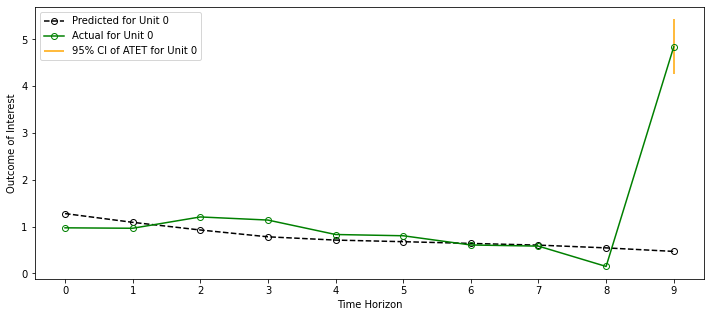

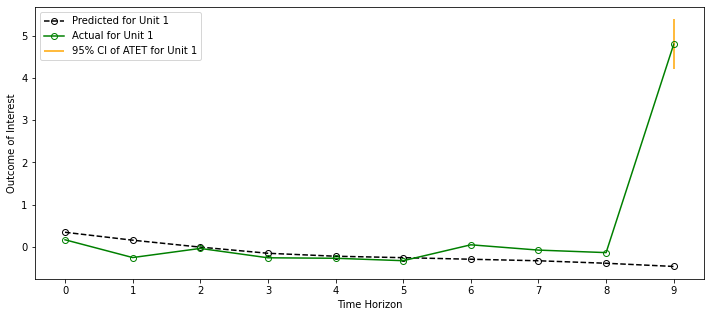

In [168]:
data_plot_ =did_twfe_results['twfe_c'].loc[did_twfe_results['twfe_c']['unit_id'].isin(['0','1'])]
data_plot_.drop_duplicates(inplace=True)

for r in ['0','1']:
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(12,5))
    ax.plot(data_plot_.loc[data_plot_['unit_id']==r]['time'],
            data_plot_.loc[data_plot_['unit_id']==r]['y_hat_counterfactual'], 
            marker='o', linestyle='--',  mfc='none', 
            color='black',
            label='Predicted for Unit {0}'.format(r))
    ax.plot(data_plot_.loc[data_plot_['unit_id']==r]['time'],
            data_plot_.loc[data_plot_['unit_id']==r]['y'], 
            marker='o', linestyle='solid',  mfc='none', 
            color='green',
            label='Actual for Unit {0}'.format(r))
    ax.vlines(x=data_plot_.loc[(data_plot_['unit_id']==r) & (data_plot_['time'].isin([9])) ]['time'],
           ymin=data_plot_.loc[(data_plot_['unit_id']==r) & (data_plot_['time'].isin([9])) ]['y']-1.96*\
            data_plot_.loc[(data_plot_['unit_id']==r) & (data_plot_['time'].isin([9])) ]['y_hat_se'],
           ymax=data_plot_.loc[(data_plot_['unit_id']==r) & (data_plot_['time'].isin([9])) ]['y']+1.96*\
            data_plot_.loc[(data_plot_['unit_id']==r) & (data_plot_['time'].isin([9])) ]['y_hat_se'],
              color='orange',
             label='95% CI of ATET for Unit {0}'.format(r))
    ax.set_xticks(data_plot_.loc[data_plot_['unit_id']=='0']['time'])
    ax.set_xticklabels(data_plot_.loc[data_plot_['unit_id']=='0']['time'])
    ax.set_ylabel('Outcome of Interest')
    ax.set_xlabel('Time Horizon')
    ax.legend()
    plt.show()


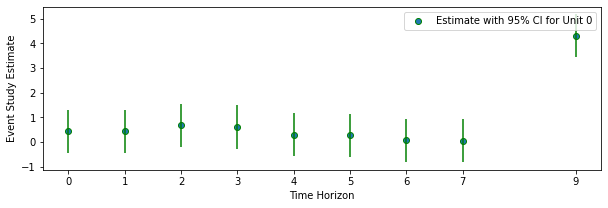

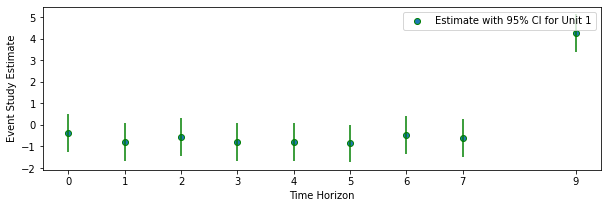

In [169]:
event_placebo_plot_ = did_twfe_results['event_study'].copy()
for r in ['0','1']:
    fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(10,3))
    ax.scatter(event_placebo_plot_.loc[event_placebo_plot_['treated_unit']==r]['time_period'].astype(int),
        event_placebo_plot_.loc[event_placebo_plot_['treated_unit']==r]['coef_'],
        marker='o', edgecolor='green', label='Estimate with 95% CI for Unit {0}'.format(r))
    ax.vlines(x=event_placebo_plot_.loc[event_placebo_plot_['treated_unit']==r]['time_period'].astype(int),
            ymin=event_placebo_plot_.loc[event_placebo_plot_['treated_unit']==r]['coef_']-1.96*\
              event_placebo_plot_.loc[event_placebo_plot_['treated_unit']==r]['se_'],
            ymax=event_placebo_plot_.loc[event_placebo_plot_['treated_unit']==r]['coef_']+1.96*\
              event_placebo_plot_.loc[event_placebo_plot_['treated_unit']==r]['se_'],          
            linestyle='solid',  color='green')
    ax.set_xticks(event_placebo_plot_.loc[event_placebo_plot_['treated_unit']==r]['time_period'].astype(int))
    ax.set_xticklabels(event_placebo_plot_.loc[event_placebo_plot_['treated_unit']==r]['time_period'])
    ax.set_ylabel('Event Study Estimate')
    ax.set_xlabel('Time Horizon')
    ax.legend()
    
    plt.show()

In [170]:
display( 
    did_twfe_results['twfe_c'].loc[did_twfe_results['twfe_c']['unit_id'].isin(['0','1'])]
)
display( 
    did_twfe_results['event_study_c'].loc[did_twfe_results['event_study_c']['unit_id'].isin(['0','1'])]
)

,unit_id,time,y,y_hats,y_hat_counterfactual,y_hat_se,coef_
0,0,0,0.972935,1.277549,1.277549,0.299545,4.372834
1,1,0,0.170687,0.348033,0.348033,0.299545,5.261749
50,0,1,0.963493,1.090289,1.090289,0.299545,4.372834
51,1,1,-0.250045,0.160774,0.160774,0.299545,5.261749
100,0,2,1.205413,0.926465,0.926465,0.299545,4.372834
101,1,2,-0.034183,-0.003051,-0.003051,0.299545,5.261749
150,0,3,1.138773,0.780783,0.780783,0.299545,4.372834
151,1,3,-0.255748,-0.148732,-0.148732,0.299545,5.261749
200,0,4,0.830135,0.710745,0.710745,0.299545,4.372834
201,1,4,-0.267082,-0.218771,-0.218771,0.299545,5.261749


,unit_id,time,y,y_hats,y_hat_counterfactual,y_hat_se,coef_
0,0,0,0.972935,0.972935,0.972935,0.000000,0.000000
1,1,0,0.170687,0.170687,0.170687,0.000000,0.000000
50,0,1,0.963493,0.963493,0.963493,0.000000,0.000000
51,1,1,-0.250045,-0.250045,-0.250045,0.000000,0.000000
100,0,2,1.205413,1.205413,1.205413,0.000000,0.000000
101,1,2,-0.034183,-0.034183,-0.034183,0.000000,0.000000
150,0,3,1.138773,1.138773,1.138773,0.000000,0.000000
151,1,3,-0.255748,-0.255748,-0.255748,0.000000,0.000000
200,0,4,0.830135,0.830135,0.830135,0.000000,0.000000
201,1,4,-0.267082,-0.267082,-0.267082,0.000000,0.000000


SC Model Examples

In [171]:
## Clean data
sc_dict = dgp.clean_and_input_data(dataset=df,
                                   treatment='treated',
                                   unit_id='unit_id',
                                   date='time',
                                   post='post',
                                  outcome='y')

# ## Figure out the alpha and lambda values
# w=alpha_lambda.get_alpha_lambda(sc_dict['C_pre'])
# alpha_lambda_to_use = alpha_lambda.alpha_lambda_transform(w.x)
# ## Take the alpha and lambda values, and estimate mu and omega
# di_est = di.predict_mu_omega(sc_dict['T_pre'], sc_dict['C_pre'], alpha_lambda_to_use, 
#                              treatment_window_pre_treatment)
# di_output = di.sc_style_results(sc_dict['T_pre'], sc_dict['T_pst'],
#                     sc_dict['C_pre'], sc_dict['C_pst'],
#                         di_est['mu'],di_est['omega'])
# di_validation = sc.sc_validation(treatment_pre=sc_dict['T_pre'], 
#                  treatment_pst=sc_dict['T_pst'],
#                  control_pre=sc_dict['C_pre'],
#                  control_pst=sc_dict['C_pst'], 
#                  mu=di_est['mu'],
#                  omega=di_est['omega'],
#                  pre_treatment_window=treatment_window_pre_treatment)
# cl_output['predict_est']

# ak7 = cl.predict_mu_omega(sc_dict['T_pre'], sc_dict['C_pre'], treatment_window_pre_treatment)
# cl_output = di.sc_style_results(sc_dict['T_pre'], sc_dict['T_pst'],
#                     sc_dict['C_pre'], sc_dict['C_pst'],
#                     ak7['mu'], ak7['omega'])
# sc_validation = sc.sc_validation(treatment_pre=sc_dict['T_pre'], 
#                  treatment_pst=sc_dict['T_pst'],
#                  control_pre=sc_dict['C_pre'],
#                  control_pst=sc_dict['C_pst'], 
#                  mu=ak7['mu'],
#                  omega=ak7['omega'],
#                  pre_treatment_window=treatment_window_pre_treatment)



In [172]:
f3 = sc.sc_model(model_name='adh',
        data=df,
        data_dict={'treatment': 'treated',
                  'date':'time',
                  'post':'post',
                  'unitid':'unit_id',
                  'outcome':'y'},
        pre_process_data=None,
                 aggregate_pst_periods=True,
        pre_treatment_window=None,
        inference={'alpha':0.05, 'theta_grid':np.arange(-2,8,0.0151)})
display( f3['results_df'] )



Using ADH


,atet,pvalues,ci_lower,ci_upper,alpha,test_pre_train_MAPE,test_pre_test_MAPE,test_pst_test_MAPE
0,4.403340,0.0,4.1759,4.6289,0.05,0.079417,0.619410,1.251182
1,4.671331,0.0,4.0551,5.2933,0.05,3.077485,1.847041,6.887697


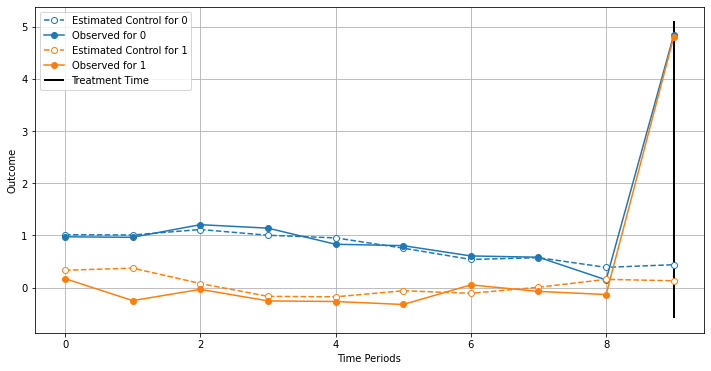

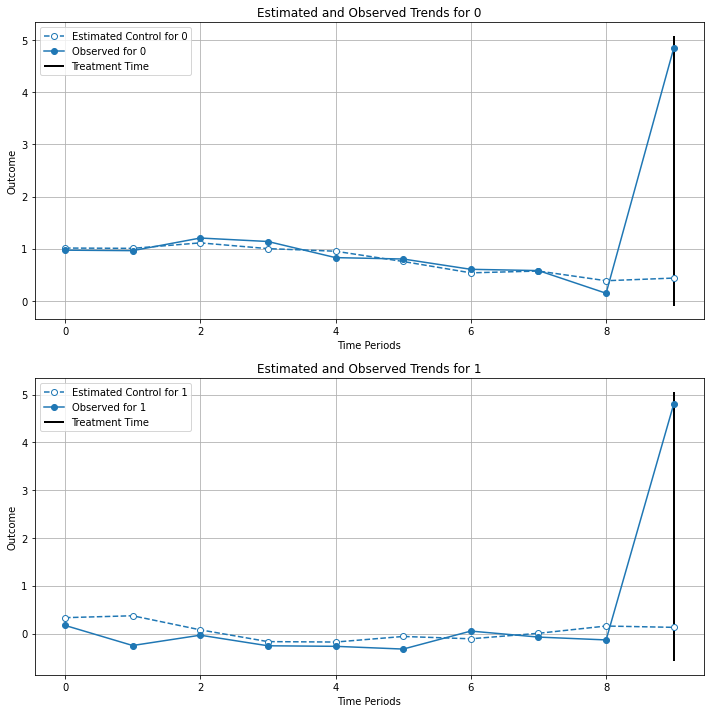

In [173]:
sc.sc_generate_figures(final_sc_output=f3,
                           output_figure_name=None)